# Tutorial 1: 10x Visium (DLPFC dataset)

In this tutorial, we demonstrate how to use S3RL to identify spatial domains in the human dorsolateral prefrontal cortex (DLPFC), specifically on slice 151509 from the 10x Genomics Visium dataset. This dataset, originally published by Maynard et al., includes high-resolution spatial transcriptomics data with manual annotations of six cortical layers and the white matter (WM), based on histological morphology and spatial gene expression patterns.

We use S3RL to jointly model spatial coordinates, histology images, and gene expression data to achieve accurate and biologically meaningful spatial segmentation. The enhanced embeddings produced by S3RL exhibit improved boundary sharpness and inter-layer separability compared to existing methods.

The processed data for DLPFC slices are available at:
👉 https://github.com/LieberInstitute/spatialLIBD?tab=readme-ov-file#raw-data

The manual annotation files for ground truth cortical layers can be accessed from the spatialLIBD package or directly downloaded here:
👉 https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing

This slice (151509) is one of the benchmark samples used in the main experiments and can be used to validate layer-aware clustering and downstream gene expression analysis using the S3RL framework.

**Prepare the data**

In [ ]:
import scanpy as sc
import os
import cv2
from S3RL import process_data
import pandas as pd
import numpy as np

path = '../Data'
dataset = 'DLPFC'
id = '151509' 
knn=7
pixel_size = 16
path_semantic_fea = 'Img_encoder/models/'

adata = sc.read_h5ad(os.path.join(path, dataset, id, 'sampledata.h5ad'))
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000, check_values=False)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Ann_df = pd.read_csv(os.path.join(path, dataset, id, 'annotation.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
drop = Ann_df.loc[adata.obs_names, 'Ground Truth'].isna()
adata = adata[~drop]
adata = adata[:, adata.var['highly_variable']]

image = cv2.imread(os.path.join(path, dataset, id, 'spatial/full_image.tif'))
semantic_fea = np.load(os.path.join(path_semantic_fea, dataset, id, 'img_emb.npy'))
adata = process_data(adata, image, pixel=pixel_size, knn=knn, edge_image=True, semantic_fea=semantic_fea)

**Train the model**

In [2]:
from S3RL.model import S3RL
import yaml
import torch
from sklearn.metrics import adjusted_rand_score

device = torch.device("cuda:0")
C = len(set(Ann_df[Ann_df['Ground Truth'].notna()]['Ground Truth'].values.tolist()))
cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, id+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

model = S3RL(adata, n_clu=C, device=device, **cfg)

adata = model.train()

Training the S3RL model:  11%|█         | 224/2000 [00:11<01:33, 19.03it/s]

Reached the tolerance, early stop training at epoch 224


In [3]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
ground_truth = adata.obs['Ground Truth'].astype('category').cat.codes.values
print('ARI is', adjusted_rand_score(ground_truth, adata.obs['pred']))

ARI is 0.6847448790101671


**Visualize the results**

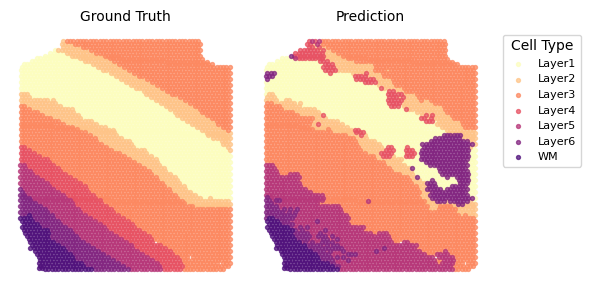

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from S3RL.tools import hungarian_match

label_pred = hungarian_match(ground_truth, adata.obs['pred'])
label_dict = dict(zip(ground_truth, adata.obs['Ground Truth'].values))

cmap = 'magma'
c_list = plt.get_cmap(cmap)(np.linspace(0, 1, 9))[::-1]
loc = adata.obsm['spatial'] * np.array([1, -1])

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
for k, label in enumerate(set(ground_truth)):
    ax[0].scatter(loc[ground_truth==label, 0], loc[ground_truth==label, 1], color=c_list[k], s=8, alpha=0.75, label=label_dict[k])
    ax[1].scatter(loc[label_pred==label, 0], loc[label_pred==label, 1], color=c_list[k], s=8, alpha=0.75, label=label_dict[k])
    
for axis in ax:
    for sp in axis.spines.values():
        sp.set_visible(False)
    axis.set_xticks([])
    axis.set_yticks([])
ax[0].set_title('Ground Truth', fontsize=10)
ax[1].set_title('Prediction', fontsize=10)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title='Cell Type', title_fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
import scanpy as sc
import os
import cv2
from S3RL.process_data import process_data
import pandas as pd
import numpy as np

path = '../Data'
dataset = 'DLPFC'
id = '151673' 
knn=7
pixel_size = 16
path_semantic_fea = 'Img_encoder/models/'

adata = sc.read_h5ad(os.path.join(path, dataset, id, 'sampledata.h5ad'))
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000, check_values=False)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Ann_df = pd.read_csv(os.path.join(path, dataset, id, 'annotation.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
drop = Ann_df.loc[adata.obs_names, 'Ground Truth'].isna()
adata = adata[~drop]
adata = adata[:, adata.var['highly_variable']]

image = cv2.imread(os.path.join(path, dataset, id, 'spatial/full_image.tif'))
semantic_fea = np.load(os.path.join(path_semantic_fea, dataset, id, 'img_emb.npy'))
adata = process_data(adata, image, pixel=pixel_size, knn=knn, edge_image=True, semantic_fea=semantic_fea)

In [6]:
from S3RL.model import S3RL
import yaml
import torch
from sklearn.metrics import adjusted_rand_score

device = torch.device("cuda:0")
C = len(set(Ann_df[Ann_df['Ground Truth'].notna()]['Ground Truth'].values.tolist()))
cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, id+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

model = S3RL(adata, n_clu=C, device=device, **cfg)

adata = model.train()

Training the S3RL model:  29%|██▉       | 575/2000 [00:21<00:54, 26.16it/s]

Reached the tolerance, early stop training at epoch 575


In [7]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
ground_truth = adata.obs['Ground Truth'].astype('category').cat.codes.values
print('ARI is', adjusted_rand_score(ground_truth, adata.obs['pred']))

ARI is 0.6401756503930481


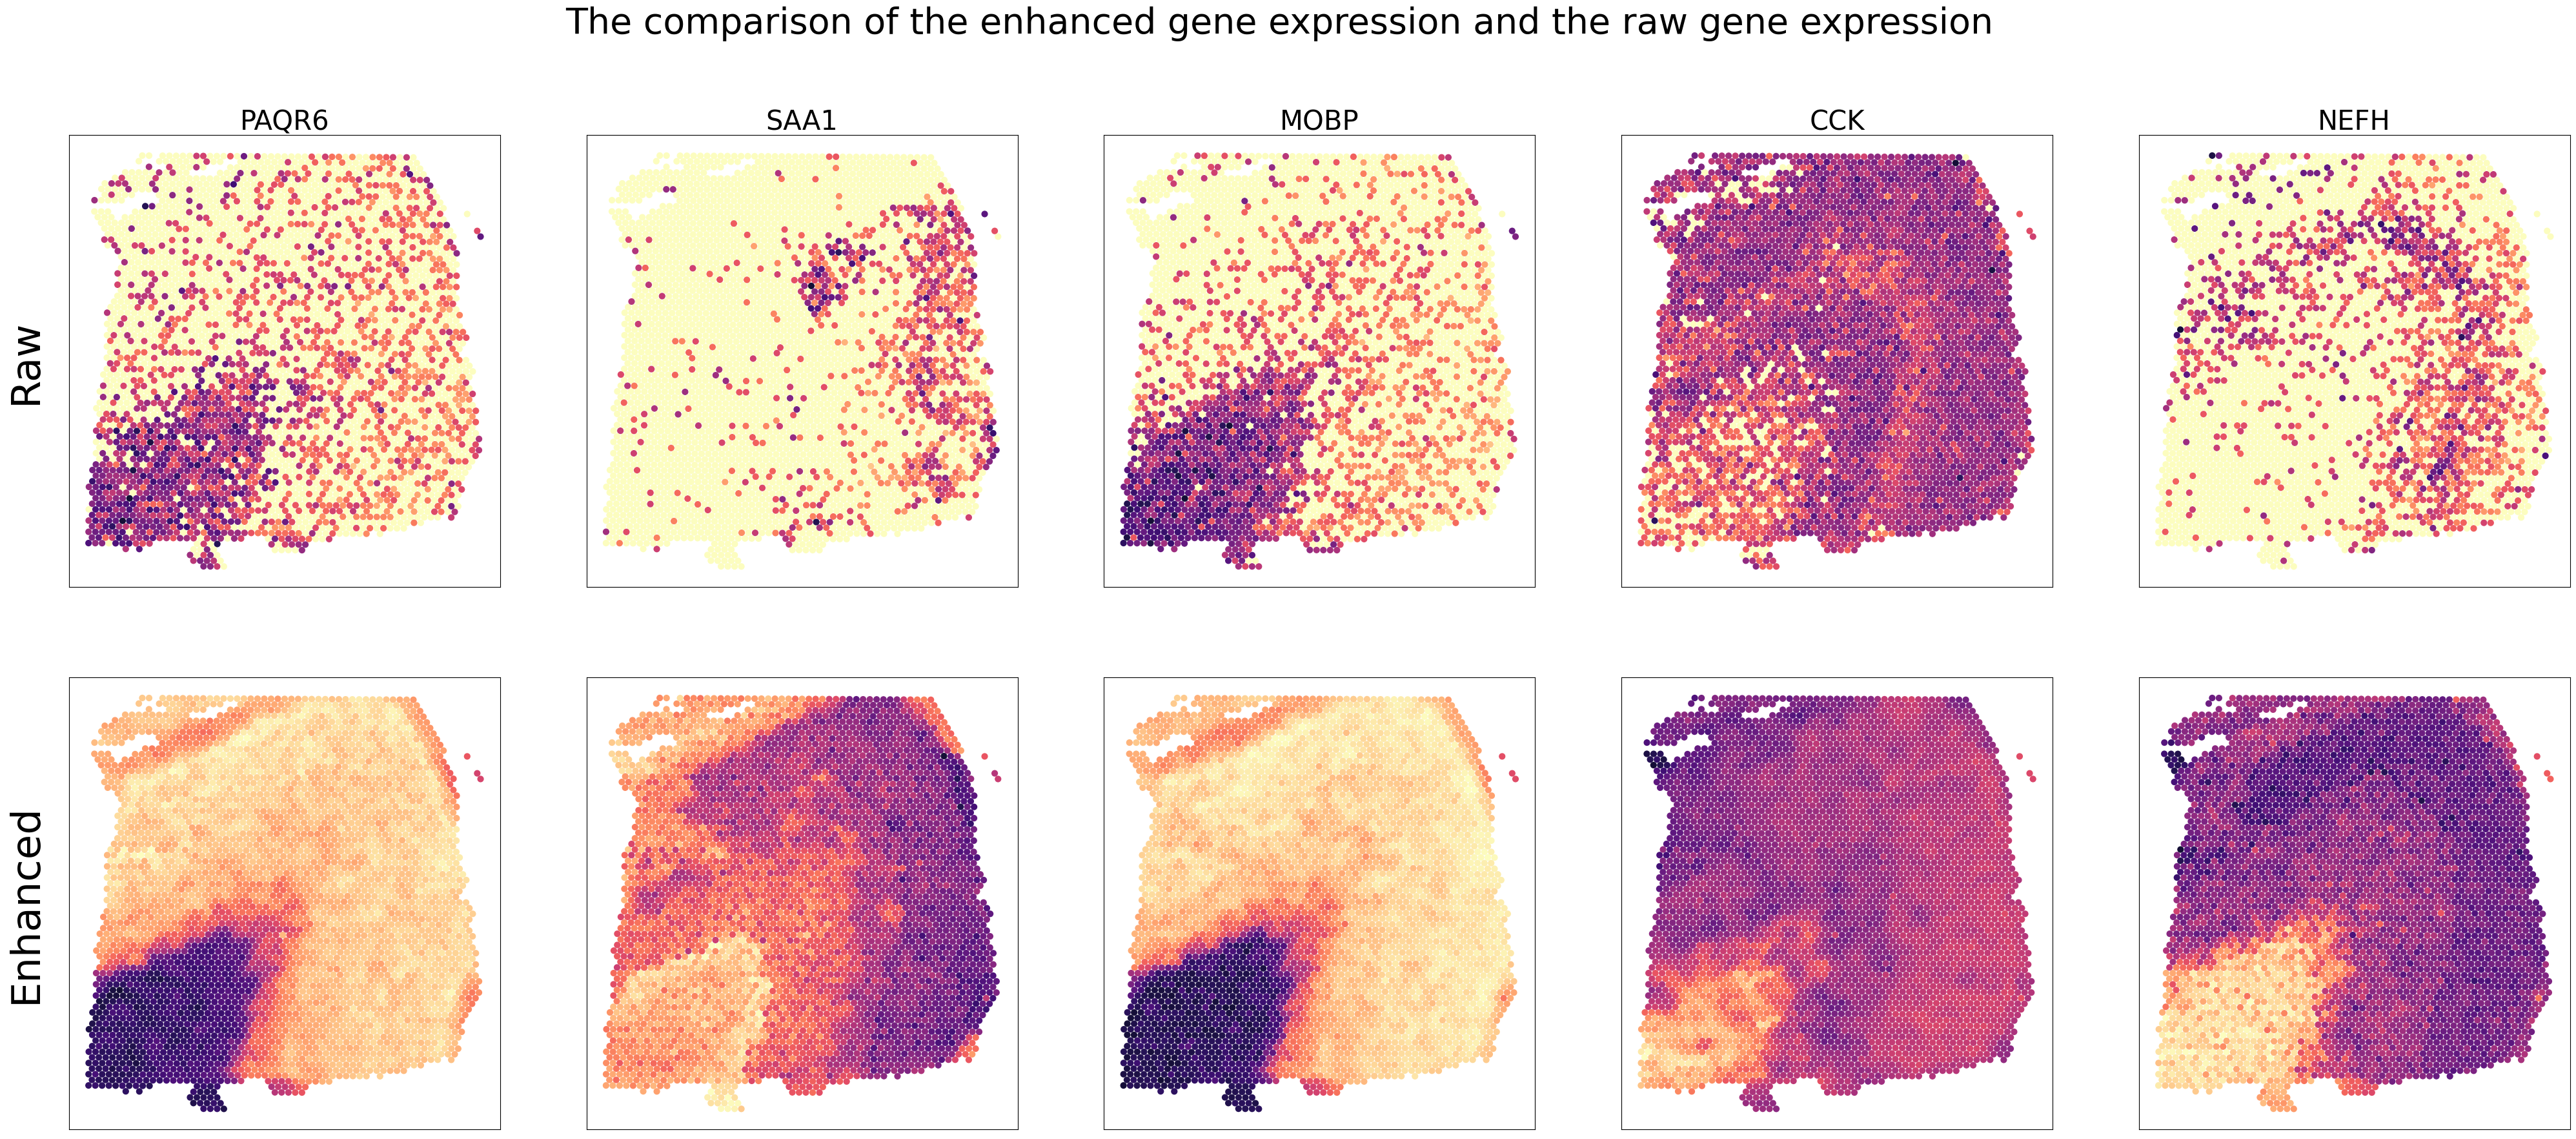

In [8]:
import matplotlib.colors as mcolors

cmap = 'magma'
gene_names = ['PAQR6', 'SAA1', 'MOBP', 'CCK', 'NEFH']

full_cmap = plt.get_cmap('magma')
start, stop = 0.1, 1.0
colors = full_cmap(np.linspace(start, stop, 256))[::-1]
ours_cmp = mcolors.LinearSegmentedColormap.from_list("RdPu_middle", colors)

loc = adata.obsm['spatial'] * np.array([1, -1])
recon_nonzero = np.where(adata.obsm['X_recon']<0, 0, adata.obsm['X_recon'])

fig, ax = plt.subplots(2, len(gene_names), figsize=(50, 20))
size = 40

for k, gene_name in enumerate(gene_names):
    idx = adata.var_names.to_list().index(gene_name)

    ax[0, k].scatter(loc[:, 0], loc[:, 1], c=adata.X[:, idx].tolist(), cmap=ours_cmp, s=size, alpha=1.0)
    ax[1, k].scatter(loc[:, 0], loc[:, 1], c=recon_nonzero[:, idx].tolist(), cmap=ours_cmp, s=size)

    ax[0, k].set_xticks([])
    ax[0, k].set_yticks([])
    
    ax[1, k].set_xticks([])
    ax[1, k].set_yticks([])
    
    ax[0, k].set_title(gene_name, fontsize=30)

ax[0, 0].text(-0.1, 0.5, 'Raw', ha='center', va='center', fontsize=45, transform=ax[0, 0].transAxes, rotation=90)
ax[0, 1].text(-0.1, 0.5, 'Enhanced', ha='center', va='center', fontsize=45, transform=ax[1, 0].transAxes, rotation=90)

fig.suptitle('The comparison of the enhanced gene expression and the raw gene expression', fontsize=40)
plt.show()

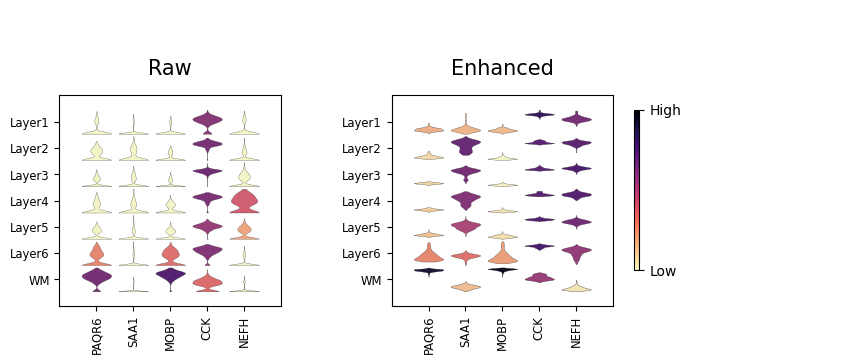

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


adata.X /= adata.X.max(axis=0, keepdims=True)
adata_recon = adata.copy()
adata_recon.X = recon_nonzero / (recon_nonzero.max(axis=0, keepdims=True) + 1e-10)

cmap = mcolors.LinearSegmentedColormap.from_list("custom", plt.get_cmap('magma').colors[::-1])
norm = mcolors.Normalize(vmin=0, vmax=1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, data in enumerate([adata, adata_recon]):
    d = sc.pl.stacked_violin(data, gene_names, groupby='Ground Truth', vmax=1, ax=ax[i], show=False, cmap=cmap)
    d['color_legend_ax'].remove()
    ax[i].text(0.25, 0.8, ['Raw', 'Enhanced'][i], ha='center', va='center', fontsize=15, transform=ax[i].transAxes)


cbar = fig.colorbar(mappable, cax=fig.add_axes([0.7, 0.2, 0.005, 0.4]))
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Low', 'High'])

fig.subplots_adjust(top=0.85, wspace=-0.25)